# Initial analysis

Improvements (/TODOs) from meeting #7 (14/11/2023):
1. Careful with use of MC variables (i.e. the `'All'` suffix keys)!
2. Following from (1), check code for signal to background ratio... do not use MC keys
3. Check how I am calculating what data is background and what data is selected
    - Signal data $\neq$ selected data!
4. Refactor the `calc_cuts` (and the corresponding print) function to calculate how much **signal** data is being thrown away
    - Again, signal data $\neq$ selected data!!
5. Following from (4), plot for each of the cuts histograms showing whcih cuts are signal and which are background
6. By seeing how many of the signal events are being thrown away, is there a way that we can improve the selections so we retain more of the signal events (i.e. try improve the efficiency) using ML?
7. Update the key documentation... (look at notes below)
8. A correlation of 0.6 is actaully pretty high, have another look at the correlation matrix and see what more I can learn...
9. (Shorten the notebook down, and clean up my code...)

Other things to note:
- The `rec` in the key names $\neq$ 'reconstructed', but rather 'record'
- The `slc` refers to a time-'slice'
- `cosmic` and `kalman` refer to the different algorithms used... (Kalman is the latest)

### 1. Imports

In [2]:
import os

import dotenv
dotenv.load_dotenv()

import h5py

import numpy as np

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt


In [3]:
# Typing Stuff
from typing import Dict
from typing import Any
from typing import Tuple
from typing import Callable

### 2. Loading the data...

In [4]:
# Notes:
#   - Don't forget to close the file.
#   - The full dataset is stored locally.

my_data = h5py.File(os.environ['MINI_DATA_DIR'], 'r')

In [5]:
# for key in my_data.keys():
#     print('Parent Key:', key)
#     try:
#         print('\tChildren Keys:', my_data[key].keys())
#     except AttributeError:
#         pass

From the code cell above (might be commeted out for you) we can see that the simplified ("mini") dataset does not have any child keys! The bigger dataset (used in 'ref/pidFunSelNotSel.ipynb'), however, does have several child keys for some of the parent keys.

Therefore, only the most essential data is probably stored in this "mini" dataset.

Update: After further analysis of the code, the columns with suffix 'All' were made using the parameters from the bigger dataset...

Furthermore, the data is focusing on $\nu_\mu$ (or hadronic events) hence stuff about $\nu_\text{e}$ or $\nu_\tau$ is mostly ignored in this dataset.

#### 2.1 Information about all the keys in the file above...

Few things to note, I was able to produce this "documentation" by looking at the data types, their correlation values with certain variables (e.g., `'isCC'` is correlated to `'isNuMuCC'`) and later in Sec. 4 by looking at their distributions.

- `'3flavourveto'` : (bool) ?? --> Check how this was defined!
- `'cosBeamFirst'` : cos(Angle off beam axis) between [0, 1] (float32)

**Reduced parameters**

- `'pdgAll'`  : Relevant PDGIDs (refer to [this](https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf)) could be one of three: 0, $\pm$ 12 ($\nu_\text{e}$ or $\bar{\nu}_\text{e}$), or $\pm$ 14 ($\nu_\mu$ or $\bar{\nu}_\mu$) (int16).

**Flags** (bool)

- `'isANuECC'`    : $\bar{\nu}_\text{e}$ CC events
- `'isANuMuCC'`   : $\bar{\nu}_\mu$ CC events
- `'isCC'`        : Charged current events
- `'isNC'`        : Neutral current events
- `'isNotNu'`     : Non-$\nu$ events
- `'isNuECC'`     : Elastic CC events
- `'isNuMu'`      : Muon-neutrino events
- `'isNuMuCC'`    : Muon-neutrino CC events
- `'ccAll'`       : Flag for all CC events (uint16)
- `'modeAll'`     : Interaction mode (e.g. 0 means a QE interaction) 

**Cuts** (bool)

- `'numu2020pid'`        : Muon-neutrino CVN PID cut
- `'numuBasicQuality'`   : Basic quality cut
- `'numuQuality'`        : Quality cut
- `'numucontain'`        : Muon-neutrino containment cut
- `'numucosrej'`         : Cosmic rejection cut
- `'numufull'`           : Events that pass all the cuts
- `'numunotpid'`         : Events that pass all cuts except CVN PID

**Momentum** (float32)

- `'pmu'`  : Muon momentum $p$ [GeV]
- `'pt'`   : Transverse momentum $p_t$ [GeV]
- `'ptp'`  : $p_t / p$

**Reconstructed stuff**

- `'rec.energy.numu.E'`              : $\nu_\mu$ candidate energy [GeV] (float32)
- `'rec.energy.numu.calccE'`         : Calorimetric CC energy [GeV] (float32)
- `'rec.energy.numu.lstmmuon'`       : LSTM Predicted $\nu_\mu$ energy [GeV] (float32)
- `'rec.energy.numu.lstmnu'`         : LSTM Predicted $\nu$ energy [GeV] (float32)
- `'rec.energy.numu.hadcalE'`        : Total energy of the Hadronic tracks [GeV] (Note: Should equal to the sum of `'rec.energy.numu.hadclust.calE'` and `'rec.energy.numu.hadtrkE'`) (float32)
- `'rec.energy.numu.hadclust.calE'`  : Hadronic calorimetric energy [GeV] (float32)
- `'rec.energy.numu.hadtrkE'`        : Hadronic track energy [GeV] (float32) ??
- `'rec.energy.numu.regcvnhadE'`     : Regression CVN hadronic energy [GeV] (float32)
- `'rec.energy.numu.hadclust.nhit'`  : Number of hadronic hits (uint32)
- `'rec.mc.nnu'`                     : Flag for $\mu$ events according to MC simulation (int16)
- `'rec.sel.contain.cosbakcell'`     : (int32) ??

**Pre-selection CVN**: Scores used to predict the type of particle interaction (float32)

- `'rec.sel.cvnloosepreselptp.cosmicid'` - Cosmogenic events
- `'rec.sel.cvnloosepreselptp.ncid'`     - NC events
- `'rec.sel.cvnloosepreselptp.nueid'`    - $\nu_\text{e}$ events
- `'rec.sel.cvnloosepreselptp.numuid'`   - $\nu_\mu$ events
- `'rec.sel.cvnloosepreselptp.nutauid'`  - $\nu_\tau$ events

**More selection stuff** (float32)

- `'rec.sel.remid.pid'`                  : 
- `'rec.sel.scann.scpid'`                : 
- `'rec.slc.ncontplanes'`                : Number of planes that contain the track ??
- `'rec.slc.nhit'`                       : 

**Reconstructed track data** (??)

- `'rec.trk.cosmic.ntracks'` : Reconstructed cosmic tracks (uint64) (Note: All equal 1??)
- `'rec.trk.kalman.ntracks'` : Muon tracks produced by Kalman filter ?? (uint64)
- `'recoq2'`                 : Reconstructed $Q^2$ [GeV^2] (float32)
- `'recow'`                  : Reconstructed hadronic invariant mass (float32) (Note: Half of these were null)
- `'trueEnu'`                : True energy of the $\nu$ in our simulation (float32)


#### 2.2 More observations:

- Cuts could have been applied to this dataset to remove (most) of the $\nu_\text{e}$ events, so the main focus of this dataset is on $\nu_\mu$ events. Otherwise, this is only the case in the small sample that I used...

- The plotted energy distributions are less "spread" out than the distributions seen in the [results](https://doi.org/10.1103/PhysRevD.106.032004). This could be due to the method of binning employed in their analysis: "variable neutrino energy binning with finer bins near the disapearance maximum and coarser bins elsewhere".

### 3. Getting Started

First, I want to see what the data looks like, and the most convinent method of doing this this using the Pandas library. I will first load the first 1,000 or so records from the H5 file to a Python dictionary and then load this into a Pandas `DataFrame`.

Update: In later version of this code, I decided that I could use more data so I have pulled the first 2,000,0000 records!

In [6]:
# Number of records I want to pull from the H5 file
n_records = 2_000_000

In [7]:
data: Dict[str, Any] = {
    key:my_data[key][:n_records] for key in my_data.keys()
}

df = pd.DataFrame(data)

del data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 48 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   3flavourveto                        bool   
 1   ccAll                               uint16 
 2   cosBeamFirst                        float32
 3   isANuECC                            bool   
 4   isANuMuCC                           bool   
 5   isCC                                bool   
 6   isNC                                bool   
 7   isNotNu                             bool   
 8   isNuECC                             bool   
 9   isNuMu                              bool   
 10  isNuMuCC                            bool   
 11  modeAll                             int32  
 12  numu2020pid                         bool   
 13  numuBasicQuality                    bool   
 14  numuQuality                         bool   
 15  numucontain                         bool   
 16  

In [9]:
# I wrote the stuff below to seperate HTML documents...
# - `df.to_html()`
# - `df.corr().style.background_gradient(cmap='coolwarm')`
# - `df.describe().to_html()`

Out of all the columns, we can see that `'recow'` (reconstructed hadronic invariant mass) is the only one that contains null values! Why this happens we can explore later in the notebook...

For now, the NaN values will be replaced with 0.

In [98]:
# df['recow'] = df['recow'].fillna(value=0)
# This was not a good idea...

In [99]:
def cal_max_score_col(data: pd.DataFrame) -> pd.Series:
    """\
    ...
    """
    temp_df = pd.DataFrame(
        {
            'Cosmic': data['rec.sel.cvnloosepreselptp.cosmicid'],
            'NC'    : data['rec.sel.cvnloosepreselptp.ncid'],
            'NuE'   : data['rec.sel.cvnloosepreselptp.nueid'],
            'NuMu'  : data['rec.sel.cvnloosepreselptp.numuid']
        }
    )
    return temp_df.idxmax(axis=1)

In [100]:
df['cvnloose.result'] = cal_max_score_col(df)

In [11]:
EVENT_INFO_STR = """\
== Event Info =============================================
|
|   Flavour                     {0}
|   Interaction                 {1}
|
|   Nu Energy                   {2:0.3f} GeV
|   Cos(Theta)                  {3:0.3f} deg
|
|   Reconstructed:
|
|       Nu Energy               {4:0.3f} GeV
|       Q-squared               {5:0.3f} GeV
|       Hadronic Inv. Mass      {6:0.3f} GeV
|       # of Hadronic Hits      {7}
|
|   LSTM Predictions:
|
|       Nu Energy               {8:0.3f} GeV
|       Muon Energy             {9:0.3f} GeV
|
|   Regression CVN Prediction:
|
|       Hadronic Energy         {10:0.3f} GeV
|
|   Cuts:
|
|       Quality                 {11}
|       Containment             {12}
|       Pre-selection CVN       ------>  Likely {13} ?
|       Cosmic Rejection        {14}
|       Hadronic (NuMu) CNV     {15}
| 
===========================================================
"""


def print_event_info(event: pd.Series) -> None:
    """\
    Prints some of the important details of the event.

    Args:
    -----
    event: pd.Series
        Event data. This is simply a row/record of the loaded `pd.DataFrame`.
    """
    flavour = 'Unknown'
    current = ''
    
    if event['isCC']:
        current = 'CC'

    if event['isNC']:
        current = 'NC'
    
    anti_prefix = 'Anti-' if event['pdgAll'] < 0 else ''

    if event['isNotNu']:
        flavour = 'N/A'
    else:
        if abs(event['pdgAll']) == 12:
            flavour = 'NuE'
        elif abs(event['pdgAll']) == 14:
            flavour = 'NuMu'
        elif abs(event['pdgAll']) == 16:
            flavour = 'NuTau'

    mode_ref_table: Dict[int, str] = {
        -1 : 'Unknown',      
        0  : 'QE',
        1  : 'Res',
        2  : 'DIS',
        3  : 'Coh',
        4  : 'CohElastic',
        5  : 'ElectronScattering',
        6  : 'IMDAnnihilation',
        7  : 'InverseBetaDecay',
        8  : 'GlashowResonance',
        9  : 'AMNuGamma',
        10 : 'MEC',
        11 : 'Diffractive',
        12 : 'EM',
        13 : 'WeakMix'
    }

    pre_sel_cvn_scores: Dict[str, float] = {
        'Cosmic': event['rec.sel.cvnloosepreselptp.cosmicid'],
        'NC'    : event['rec.sel.cvnloosepreselptp.ncid'],
        'NuE'   : event['rec.sel.cvnloosepreselptp.nueid'],
        'NuMu'  : event['rec.sel.cvnloosepreselptp.numuid'],
        # 'NuTau' : event['rec.sel.cvnloosepreselptp.nutauid'],
        # Tau events are ignored due to weird scores...
    }

    high_pre_sel_cvn_score_index = np.argmax(list(pre_sel_cvn_scores.values()))

    quality_cuts = event['numuBasicQuality'] and event['numuQuality']

    print(
        EVENT_INFO_STR.format(
            #
            anti_prefix + flavour,
            mode_ref_table[event['modeAll']] + ' ' + current,
            
            # True values
            event['trueEnu'],
            event['cosBeamFirst'],

            # Reconstructed
            event['rec.energy.numu.E'],
            event['recoq2'],
            event['recow'].fillna(value=0),
            event['rec.energy.numu.hadclust.nhit'],

            # Predictions
            event['rec.energy.numu.lstmnu'],
            event['rec.energy.numu.lstmmuon'],
            event['rec.energy.numu.regcvnhadE'],

            # Cuts
            'Passed' if quality_cuts else 'Failed',
            'Passed' if event['numucontain'] else 'Failed',
            list(pre_sel_cvn_scores)[high_pre_sel_cvn_score_index],
            'Passed' if event['numucosrej'] else 'Failed',
            'Passed' if event['numu2020pid'] else 'Failed'
        )
    )


In [12]:
print_event_info(event=df.iloc[np.random.randint(0, n_records)])

== Event Info =============================================
|
|   Flavour                     N/A
|   Interaction                 QE 
|
|   Nu Energy                   0.000 GeV
|   Cos(Theta)                  0.100 deg
|
|   Reconstructed:
|
|       Nu Energy               3.246 GeV
|       Q-squared               8.007 GeV
|       Hadronic Inv. Mass      0.000 GeV
|       # of Hadronic Hits      6
|
|   LSTM Predictions:
|
|       Nu Energy               2.622 GeV
|       Muon Energy             1.699 GeV
|
|   Regression CVN Prediction:
|
|       Hadronic Energy         0.934 GeV
|
|   Cuts:
|
|       Quality                 Passed
|       Containment             Failed
|       Pre-selection CVN       ------>  Likely Cosmic ?
|       Cosmic Rejection        Failed
|       Hadronic (NuMu) CNV     Failed
| 



In [13]:
def calc_cuts(data: pd.DataFrame) -> Tuple[pd.DataFrame, 
                                           pd.DataFrame, 
                                           pd.DataFrame, 
                                           pd.DataFrame]:
    """\
    Calculates cuts on data.

    Args:
    -----
    data: pd.DataFrame
        Full dataset or sample of the dataset.

    Returns:
    --------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]
        ...
    """
    quality = data[data['numuBasicQuality'] & data['numuQuality']]
    containment = quality[quality['numucontain']]
    cosmic_rej = containment[containment['numucosrej']]
    numu_cvn = cosmic_rej[cosmic_rej['numu2020pid']]

    return quality, containment, cosmic_rej, numu_cvn


In [120]:
CUT_FLOW = """\
== Cut Flow ===============================================
|
|   Cut         | True Sig | True NC  | Cosmic  | Total
|   ----------- | -------- | -------- | ------- | -------
|   Raw         | {0:8} | {5:8} | {10:6.1E} | {15:6.1E}
|   Quality     | {1:8} | {6:8} | {11:6.1E} | {16:6.1E}
|   Containment | {2:8} | {7:8} | {12:6.1E} | {17:6.1E}
|   Cosmic Rej. | {3:8} | {8:8} | {13:6.1E} | {18:6.1E}
|   NuMu CNV    | {4:8} | {9:8} | {14:6.1E} | {19:6.1E}
|
===========================================================
"""


def print_cut_flow(data: pd.DataFrame) -> None:
    """\
    Prints the cut flow for signal NuMu events.

    Args:
    -----
    data: pd.DataFrame
        Full dataset or sample of the dataset.

    relative: bool
        The numbers are normalised by the original dataset length if `True`.
        Defaults to `False`.
    """
    quality, containment, cosmic_rej, numu_cvn = calc_cuts(data)

    print(
        CUT_FLOW.format(
            len(data[data['isNuMu']]),
            len(quality[quality['isNuMu']]),
            len(containment[containment['isNuMu']]),
            len(cosmic_rej[cosmic_rej['isNuMu']]),
            len(numu_cvn[numu_cvn['isNuMu']]),

            len(data[data['isNC']]),
            len(quality[quality['isNC']]),
            len(containment[containment['isNC']]),
            len(cosmic_rej[cosmic_rej['isNC']]),
            len(numu_cvn[numu_cvn['isNC']]),

            len(data[data['cvnloose.result'] == 'Cosmic']),
            len(quality[quality['cvnloose.result'] == 'Cosmic']),
            len(containment[containment['cvnloose.result'] == 'Cosmic']),
            len(cosmic_rej[cosmic_rej['cvnloose.result'] == 'Cosmic']),
            len(numu_cvn[numu_cvn['cvnloose.result'] == 'Cosmic']),

            len(data),
            len(quality),
            len(containment),
            len(cosmic_rej),
            len(numu_cvn)
        )
    )


In [121]:
print_cut_flow(df)

== Cut Flow ===============================================
|
|   Cut         | True Sig | True NC  | Cosmic  | Total
|   ----------- | -------- | -------- | ------- | -------
|   Raw         |   654505 |   116149 | 1.3E+06 | 2.0E+06
|   Quality     |   505451 |    92731 | 1.2E+06 | 1.8E+06
|   Containment |   290303 |    67693 | 1.6E+04 | 3.2E+05
|   Cosmic Rej. |   273047 |    59368 | 2.0E+03 | 2.9E+05
|   NuMu CNV    |   181981 |      509 | 0.0E+00 | 1.9E+05
|



Again, we observe that a substantial amount of data is being thrown away due to the very strict containment cuts!

### 4. Playing with the data

Below, I have plotted some of the data from the mini "mini" database... I have created a small function to display some basic stats inspired by ROOT plots.

In [17]:
def draw_plot_info(ax) -> Callable[[pd.Series, Any, str], None]:
    """\
    Draws simple stats beside the histogram axes - similar to ROOT.
    
    Args:
    -----
    ax: mpl.Axes
        Axes object of the plot (e.g. initialised via `plt.subplots`).

    Returns:
    --------
    Callable[[pd.Series, str], None]
        Function which updates the plot axes.
    """
    row = 0  # Updates the offset...
             # Plotting too many not reccomended!

    col = 0

    text_str = "{0}:\nEntries  {1}\nMean     {2:0.3f}\nStd Dev {3:0.3f}"

    def update(data: pd.Series, 
               bar_container, 
               label: str) -> None:
        """\
        Function updates the plot axes according to given data.

        Args:
        -----
        data: pd.Series
            Data plotted on the histogram. This is simply the column of the `pd.DataFrame`.

        bar_container: mpl.BarContainer
            The last thing that is retured by `plt.hist` or `ax.hist`.

        label: str
            Label of the histogram - will be drawn like a plot legend.
            
        """
        nonlocal row
        nonlocal col

        patch = bar_container.patches[0]

        bbox = dict(
            boxstyle='round', 
            facecolor=patch.get_facecolor(),
            alpha=patch.get_alpha()
        )

        ax.text(
            1.05 + 0.24 * col, 1.0 - 0.24 * row,
            text_str.format(
                label,
                len(data),
                data.mean(), 
                data.std()
            ),
            transform=ax.transAxes, 
            verticalalignment='top', 
            bbox=bbox
        )

        row += 1

        if row < 0:
            row = 0
            col += 1
    
    return update

Before I start plotting stuff, I also want to check what the original `fillTruthVars` function does to obtain the data. Namely, the stuff with `np.sum` and `np.cumsum`, and how that is used to extract certain data.

```python
def fillTruthVars(td):
    numNu=np.sum(td['rec.mc.nnu'])
    nnuIndex=np.cumsum(td['rec.mc.nnu'])
    nnuIndex=np.concatenate(([0],nnuIndex))
    nnuIndex[nnuIndex==numNu]=numNu-1  #If the last few entries are cosmics they
    print(nnuIndex[-10:]) #will try and access elements that don't exist
    td['nnuIndex']=nnuIndex
    td['pdgAll']=td['rec.mc.nu.pdg'][nnuIndex[0:-1]]*(td['rec.mc.nnu']>0.5) #The *(nnuVals>0) part sets all non-neutrinos (cosmics??) to zero for the pdg
    td['ccAll']=td['rec.mc.nu.iscc'][nnuIndex[0:-1]]*(td['rec.mc.nnu']>0.5)
    td['modeAll']=td['rec.mc.nu.mode'][nnuIndex[0:-1]]*(td['rec.mc.nnu']>0.5) #The *(nnuVals>0) part sets all non-neutrinos (cosmics??) to zero for the pdg
    td['trueEnu']=td['rec.mc.nu.E'][nnuIndex[0:-1]]*(td['rec.mc.nnu']>0.5)
    td['isNotNu']=td['rec.mc.nnu']<1
    td['isCC']=td['ccAll']>0
    td['isNC']=(td['rec.mc.nnu']*(1-td['isCC'])>0)
    td['isNuMu']=(td['pdgAll']==14)
    td['isNuMuCC']=(td['pdgAll']==14)*td['isCC']
    td['isANuMuCC']=(td['pdgAll']==-14)*td['isCC']
    td['isNuECC']=(td['pdgAll']==12)*td['isCC']
    td['isANuECC']=(td['pdgAll']==-12)*td['isCC']
```

In [18]:
# Calculating the total number of neutrino events in our mini-mini dataset
n_nu_events = np.sum(df['rec.mc.nnu'])

# Taking the cumulative sum of the neutrino events
nu_cum_sum = np.cumsum(np.array(df['rec.mc.nnu']))

print(f'{n_nu_events = }')
print(f'{nu_cum_sum[:10] = }')

n_nu_events = 701555
nu_cum_sum[:10] = array([0, 0, 0, 1, 1, 1, 2, 2, 3, 3])


In [19]:
nu_index = np.concatenate(([0], nu_cum_sum))

print(f'{nu_index[:10] = }')

nu_index[:10] = array([0, 0, 0, 0, 1, 1, 1, 2, 2, 3])


In [20]:
print(f'{(nu_index == n_nu_events) = }')

(nu_index == n_nu_events) = array([False, False, False, ...,  True,  True,  True])


As shown above this will only be true for the last two values of the cumulitive sum array. Hence, applying this as a filter we will only be left with the last two values of the array where the elements are equal to the total number of neutrino events. By setting the last two elements to `n_nu_events - 1`, we ensure that when we use this array as an index it does not raise an index error.

In [21]:
nu_index[nu_index == n_nu_events] = n_nu_events - 1

print(f'{nu_index = }')

nu_index = array([     0,      0,      0, ..., 701554, 701554, 701554])


In [22]:
_arr = np.array(df['isCC'][nu_index[0:-1]])

print(_arr[-20:])
print(f'{_arr.shape = }\n')

[False False False False  True False  True  True  True  True  True False
  True  True False False False False False False]
_arr.shape = (2000000,)



In [23]:
_arr = np.array(df['isCC'][nu_index[0:-1]] * (df['rec.mc.nnu'] > 0.5))

print(_arr[-20:])
print(f'{_arr.shape = }\n')

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
_arr.shape = (3298445,)



Why am I getting NaNs?? And why is my array bigger now?

In [24]:
_arr = (np.array(df['isCC'][nu_index[0:-1]] * (df['rec.mc.nnu'] > 0.5))) > 0

print(_arr[-20:])
print(f'{len(_arr) = }\n')

[False False False False False False False False False False False False
 False False False False False False False False]
len(_arr) = 3298445



C:\Users\Shrey\AppData\Local\Temp\ipykernel_18072\907750422.py:1: RuntimeWarning: invalid value encountered in greater
  _arr = (np.array(df['isCC'][nu_index[0:-1]] * (df['rec.mc.nnu'] > 0.5))) > 0


In [25]:
_a = len(df['isCC'][nu_index[0:-1]])
_b = len(df['rec.mc.nnu'])

print(f'len(df[\'isCC\'][nu_index[0:-1]]) = {_a}')
print(f'len(df[\'rec.mc.nnu\']) = {_b }')

len(df['isCC'][nu_index[0:-1]]) = 2000000
len(df['rec.mc.nnu']) = 2000000


Simplified example:

`isCC` array = [False, True, False, True, False]

1. Number of events array = [0, 1, 0, 1, 1]
2. Sum = 3
3. Cumulitive sum array = [0, 1, 1, 2, 3]
4. Modifying (4.) array = [0, 1, 1, 2, 2]
5. Apply index to CC array = [False, True, True, False, False]
6. 

#### 4.1 Neutrino energies

Below I am playing around with the three variables which I believe are associated with neutrino energy. I am plotting them together to get a better understanding of their mean, std. dev. and the shape of their distributions. By comparing their distributions we might get confirmation on my variable labels (in Sec. 2) or gain some insight on the nature of the experiemnt.

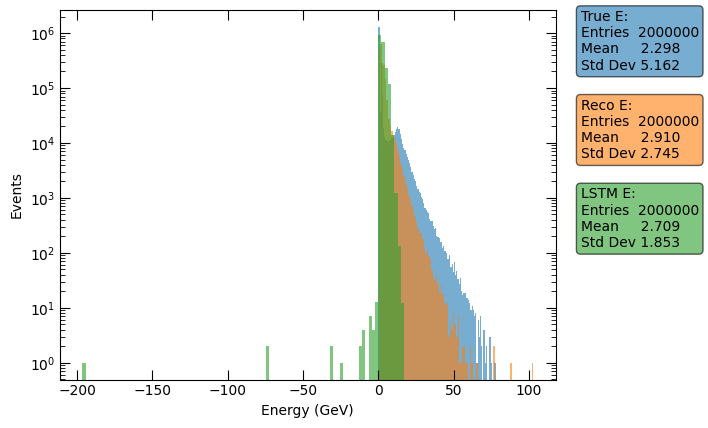

In [26]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)

# bins_conf = np.linspace(0, 1, 100 + 1)
bins_conf = 100

*_, bc = ax.hist(df['trueEnu'], bins=bins_conf, alpha=0.6)
plot_info(df['trueEnu'], bc, 'True E')

*_, bc = ax.hist(df['rec.energy.numu.E'], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'], bc, 'Reco E')

*_, bc = ax.hist(df['rec.energy.numu.lstmnu'], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.lstmnu'], bc, 'LSTM E')

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_yscale('log')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');


Why is there negative energy? Could this refer to anti-particles?

In [27]:
df[df['rec.energy.numu.lstmnu'] <= 0]['pdgAll']

13154      14
230792      0
377197      0
378968      0
382709      0
385125      0
430931      0
431624      0
432625      0
499302      0
577437     14
600676      0
600994      0
634284      0
771017      0
800832      0
812045      0
875842      0
876010      0
876124      0
1055122     0
1055283    14
1339586     0
1340069     0
1340895     0
1351493     0
1555515     0
1555637     0
1665483     0
1701273     0
1701395     0
1727922     0
1822603     0
1822710     0
1828428     0
1828641     0
1998251     0
1998379     0
Name: pdgAll, dtype: int16

In [28]:
df[df['rec.energy.numu.lstmnu'] <= 0]['isCC']

13154      False
230792     False
377197     False
378968     False
382709     False
385125     False
430931     False
431624     False
432625     False
499302     False
577437     False
600676     False
600994     False
634284     False
771017     False
800832     False
812045     False
875842     False
876010     False
876124     False
1055122    False
1055283     True
1339586    False
1340069    False
1340895    False
1351493    False
1555515    False
1555637    False
1665483    False
1701273    False
1701395    False
1727922    False
1822603    False
1822710    False
1828428    False
1828641    False
1998251    False
1998379    False
Name: isCC, dtype: bool

All their PDGIDs seem to be positive (i.e. they are not anti-particles), so it could be that the LSTM is predicting stuff weirdly. Furthermore, all the negative energy data refers to a background event (non-CC events), hence we can safely ignore this data as it will be removed by cuts. 

For now, let us reject the energy data which falls below 0 GeV since that is not physically possible.

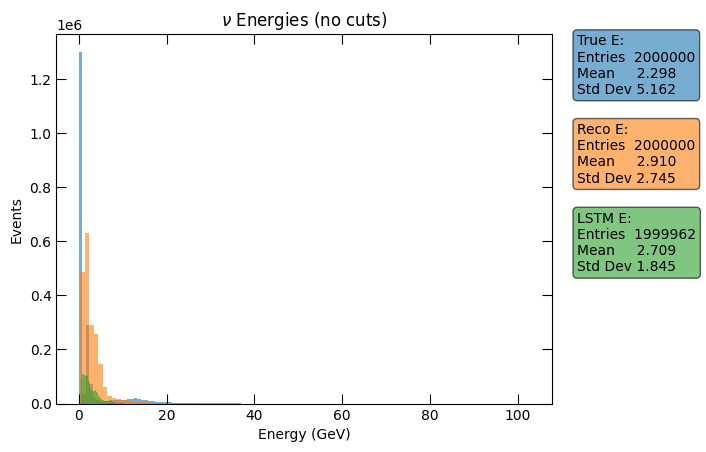

In [29]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)

# bins_conf = np.linspace(0, 1, 100 + 1)
bins_conf = 100

*_, bc = ax.hist(df['trueEnu'], bins=bins_conf, alpha=0.6)
plot_info(df['trueEnu'], bc, 'True E')

*_, bc = ax.hist(df['rec.energy.numu.E'], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'], bc, 'Reco E')

filtered_df = df[df['rec.energy.numu.lstmnu'] >= 0]

*_, bc = ax.hist(filtered_df['rec.energy.numu.lstmnu'], bins=bins_conf, alpha=0.6)
plot_info(filtered_df['rec.energy.numu.lstmnu'], bc, 'LSTM E')

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

# ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_title(r'$\nu$ Energies (no cuts)')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');


The shape of the true energy data appear to be bimodal. The reconstruction is visibly resulting in a loss of a lot of data, which could be becasue of the strict (or inefficient) cuts applied to the raw data. Furthermore, both the reconstructed data and the LSTM prediction are not bimodal, hence, they understimate (number of events) in the region of the two modes and overestimate in other regions.

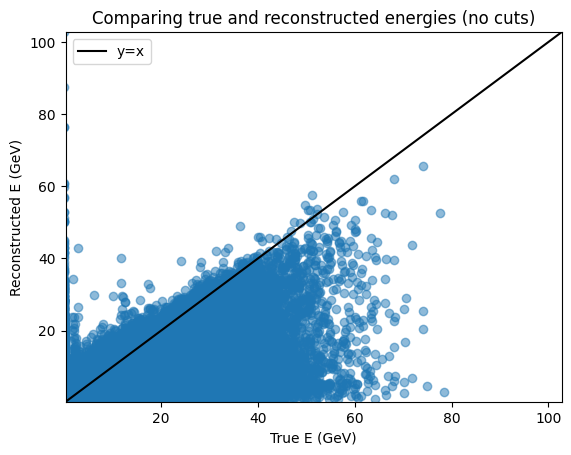

In [30]:
fig, ax = plt.subplots()

ax.plot(df['trueEnu'], df['rec.energy.numu.E'], 'o', alpha=0.5)

line_data = np.linspace(min(df['trueEnu']), max(df['rec.energy.numu.E']), 2)

ax.plot(line_data, line_data, 'k', label='y=x')

ax.legend()

ax.set_xlim(min(df['rec.energy.numu.E']), max(df['rec.energy.numu.E']))
ax.set_ylim(min(df['rec.energy.numu.E']), max(df['rec.energy.numu.E']))

ax.set_title('Comparing true and reconstructed energies (no cuts)')

ax.set_xlabel('True E (GeV)')
ax.set_ylabel('Reconstructed E (GeV)');



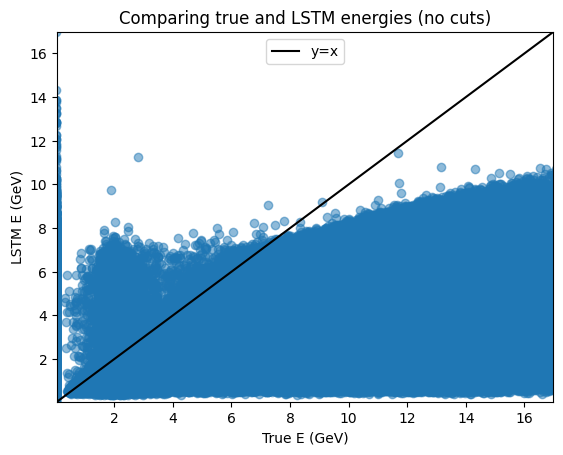

In [31]:
fig, ax = plt.subplots()

ax.plot(filtered_df['trueEnu'], filtered_df['rec.energy.numu.lstmnu'], 'o', alpha=0.5)

line_data = np.linspace(
    min(filtered_df['trueEnu']), 
    max(filtered_df['rec.energy.numu.lstmnu']), 
    2
)

ax.plot(line_data, line_data, 'k', label='y=x')

ax.legend()

ax.set_xlim(
    min(filtered_df['rec.energy.numu.lstmnu']), 
    max(filtered_df['rec.energy.numu.lstmnu'])
)
ax.set_ylim(
    min(filtered_df['rec.energy.numu.lstmnu']), 
    max(filtered_df['rec.energy.numu.lstmnu'])
)

ax.set_title('Comparing true and LSTM energies (no cuts)')

ax.set_xlabel('True E (GeV)')
ax.set_ylabel('LSTM E (GeV)');

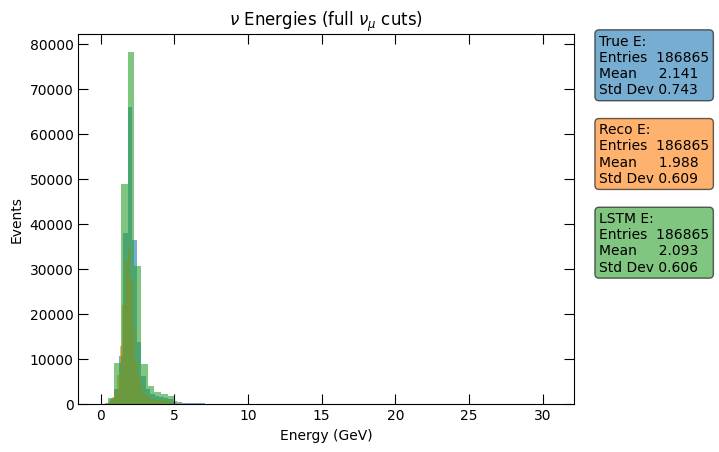

In [32]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)

# bins_conf = np.linspace(0, 1, 100 + 1)
bins_conf = 100

*_, bc = ax.hist(df['trueEnu'][df['numufull']], bins=bins_conf, alpha=0.6)
plot_info(df['trueEnu'][df['numufull']], bc, 'True E')

*_, bc = ax.hist(df['rec.energy.numu.E'][df['numufull']], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'][df['numufull']], bc, 'Reco E')

filtered_df = df[df['rec.energy.numu.lstmnu'] >= 0 & df['numufull']]

*_, bc = ax.hist(filtered_df['rec.energy.numu.lstmnu'][df['numufull']], bins=10, alpha=0.6)
plot_info(filtered_df['rec.energy.numu.lstmnu'][df['numufull']], bc, 'LSTM E')

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

# ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_title(r'$\nu$ Energies (full $\nu_\mu$ cuts)')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');


Since, we know that most neutrinos will have energies (approximately) between 0-5 GeV we can cut the rest of the data. Furthermore, I am experimenting with different methods of obtaining bin widths. Below, I used a constant width of 0.5 for all the plots. Also note, that the bins are of equal widths.

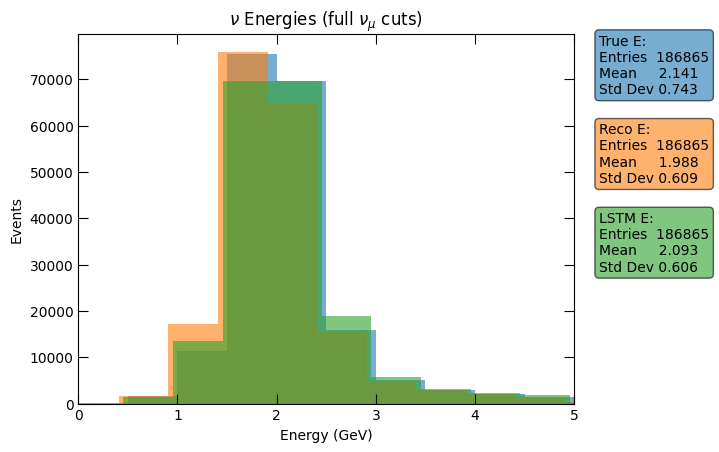

In [33]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)

# bins_conf = np.linspace(0, 1, 100 + 1)
# bins_conf = 100

bin_width = 0.5

bins_conf = np.arange(
    min(df['trueEnu'][df['numufull']]), 
    max(df['trueEnu'][df['numufull']]) + bin_width, 
    bin_width
)

*_, bc = ax.hist(df['trueEnu'][df['numufull']], bins=bins_conf, alpha=0.6)
plot_info(df['trueEnu'][df['numufull']], bc, 'True E')

bins_conf = np.arange(
    min(df['rec.energy.numu.E'][df['numufull']]), 
    max(df['rec.energy.numu.E'][df['numufull']]) + bin_width, 
    bin_width
)

*_, bc = ax.hist(df['rec.energy.numu.E'][df['numufull']], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'][df['numufull']], bc, 'Reco E')

filtered_df = df[df['rec.energy.numu.lstmnu'] >= 0 & df['numufull']]

bins_conf = np.arange(
    min(filtered_df['rec.energy.numu.lstmnu'][df['numufull']]), 
    max(filtered_df['rec.energy.numu.lstmnu'][df['numufull']]) + bin_width, 
    bin_width
)

*_, bc = ax.hist(filtered_df['rec.energy.numu.lstmnu'][df['numufull']], bins=bins_conf, alpha=0.6)
plot_info(filtered_df['rec.energy.numu.lstmnu'][df['numufull']], bc, 'LSTM E')

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_xlim(0, 5)

# ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_title(r'$\nu$ Energies (full $\nu_\mu$ cuts)')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');


The shape of the distribution, is approximately as we expect it to be. There is a single mode, centered at (or with means of) approximately 2 GeV. The plot above gives us a better picture of how well these algorithms are able to reconstruct or estimate the data. It seems that the reconstruction and prediction algorithms are particularly good when dealing with signal data. (Also, this might be a better way of binning when comparing distributions...)

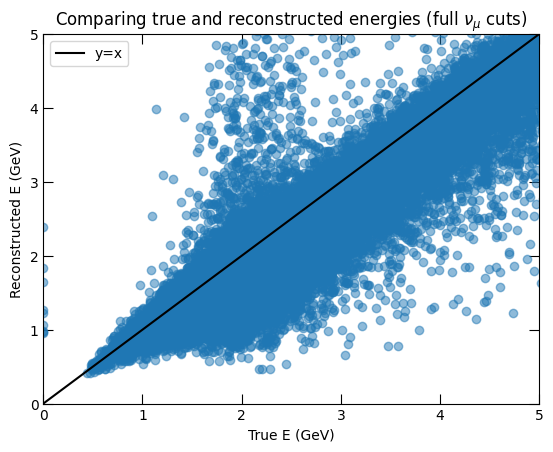

In [34]:
fig, ax = plt.subplots()

ax.plot(df['trueEnu'][df['numufull']], df['rec.energy.numu.E'][df['numufull']], 'o', alpha=0.5)

line_data = np.linspace(
    min(df['trueEnu'][df['numufull']]), 
    max(df['rec.energy.numu.E'][df['numufull']]), 
    2
)

ax.plot(line_data, line_data, 'k', label='y=x')

ax.legend()

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_xlim(0, 5)
ax.set_ylim(0, 5)

ax.set_title(r'Comparing true and reconstructed energies (full $\nu_\mu$ cuts)')

ax.set_xlabel('True E (GeV)')
ax.set_ylabel('Reconstructed E (GeV)');


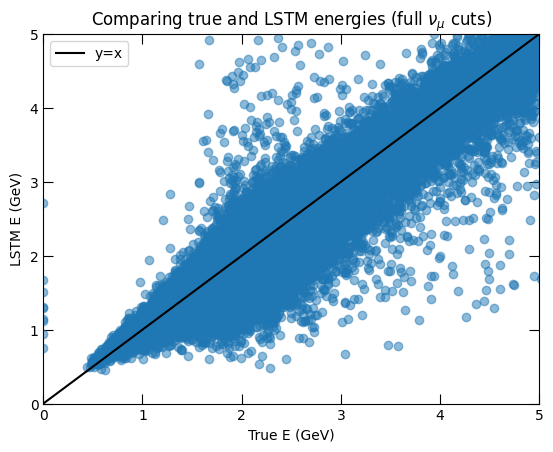

In [35]:
fig, ax = plt.subplots()

ax.plot(
    filtered_df['trueEnu'][df['numufull']], 
    filtered_df['rec.energy.numu.lstmnu'][df['numufull']], 
    'o', 
    alpha=0.5
)

line_data = np.linspace(
    min(filtered_df['trueEnu'][df['numufull']]), 
    max(filtered_df['rec.energy.numu.lstmnu'][df['numufull']]), 
    2
)

ax.plot(line_data, line_data, 'k', label='y=x')

ax.legend()

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_xlim(0, 5)
ax.set_ylim(0, 5)

ax.set_title(r'Comparing true and LSTM energies (full $\nu_\mu$ cuts)')

ax.set_xlabel('True E (GeV)')
ax.set_ylabel('LSTM E (GeV)');

Plots above show that the reconstructions and predictions follow the trend of the $y=x$ line. Another observation is that both tend to underestimate energy more frequently than overestimate it (Why does this happen?).


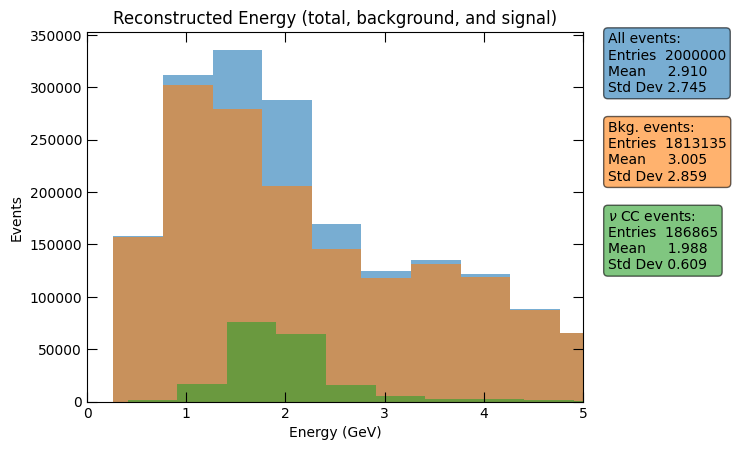

In [36]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)

# bins_conf = np.linspace(0, 1, 100 + 1)
# bins_conf = 100

bin_width = 0.5

bins_conf = np.arange(
    min(df['rec.energy.numu.E']), 
    max(df['rec.energy.numu.E']) + bin_width, 
    bin_width
)

*_, bc = ax.hist(df['rec.energy.numu.E'], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'], bc, r'All events')

bins_conf = np.arange(
    min(df['rec.energy.numu.E'][~df['numufull']]), 
    max(df['rec.energy.numu.E'][~df['numufull']]) + bin_width, 
    bin_width
)

*_, bc = ax.hist(df['rec.energy.numu.E'][~df['numufull']], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'][~df['numufull']], bc, 'Bkg. events')

bins_conf = np.arange(
    min(df['rec.energy.numu.E'][df['numufull']]), 
    max(df['rec.energy.numu.E'][df['numufull']]) + bin_width, 
    bin_width
)

*_, bc = ax.hist(df['rec.energy.numu.E'][df['numufull']], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'][df['numufull']], bc, r'$\nu$ CC events')

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_xlim(0, 5)

# ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_title(r'Reconstructed Energy (total, background, and signal)')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');


Let's plot this again, but I am copying the bin configuration from 'pidFun_reallymini.ipynb'.

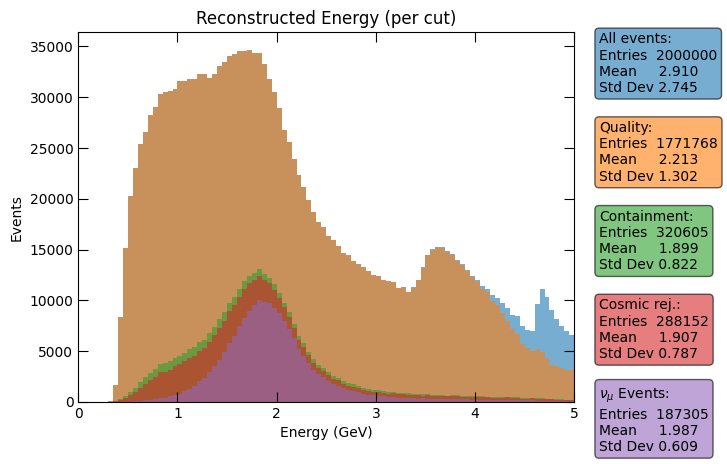

In [37]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)

bins_conf = np.linspace(0, 5, 100 + 1)

cut_labels = ['Quality', 'Containment', 'Cosmic rej.', r'$\nu_\mu$ Events']

cut_dfs = calc_cuts(df)

*_, bc = ax.hist(df['rec.energy.numu.E'], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'], bc, r'All events')

for i, cut_df in enumerate(cut_dfs):
    *_, bc = ax.hist(cut_df['rec.energy.numu.E'], bins=bins_conf, alpha=0.6)
    plot_info(cut_df['rec.energy.numu.E'], bc, cut_labels[i])

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_xlim(0, 5)

# ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_title(r'Reconstructed Energy (per cut)')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events')

del cut_dfs


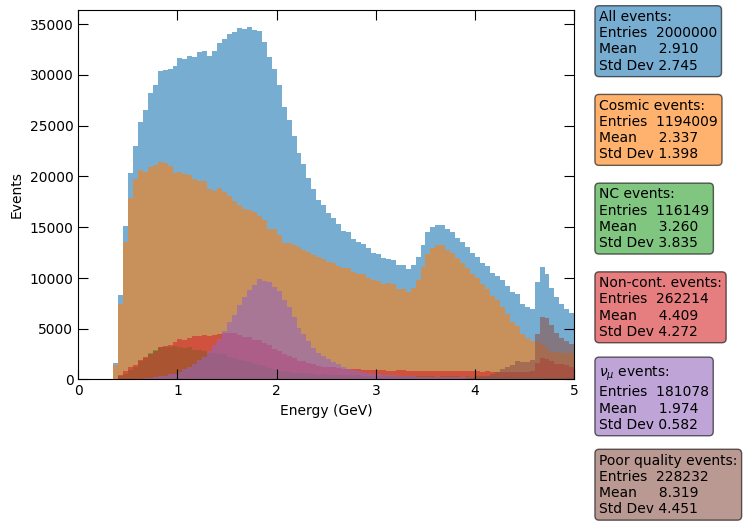

In [38]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)

bins_conf = np.linspace(0, 5, 100 + 1)

*_, bc = ax.hist(df['rec.energy.numu.E'], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'], bc, 'All events')

# All cosmic events
_i = ~df['numucosrej'] & df['numuQuality'] & df['numuBasicQuality']
*_, bc = ax.hist(df['rec.energy.numu.E'][_i], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'][_i], bc, 'Cosmic events')

# NC events
*_, bc = ax.hist(df['rec.energy.numu.E'][df['isNC']], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'][df['isNC']], bc, 'NC events')

# Non-contained signal-like events
_i = ~df['numucontain'] & df['isNuMuCC'] & df['numucosrej']
*_, bc = ax.hist(df['rec.energy.numu.E'][_i], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'][_i], bc, 'Non-cont. events')

# Signal events that pass the cuts!
_i = df['isNuMuCC'] & df['numufull']
*_, bc = ax.hist(df['rec.energy.numu.E'][_i], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'][_i], bc, r'$\nu_\mu$ events')

# Poor quality data
_i = ~(df['numuQuality'] & df['numuBasicQuality'])
*_, bc = ax.hist(df['rec.energy.numu.E'][_i], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'][_i], bc, r'Poor quality events')

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_xlim(0, 5)

# ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');


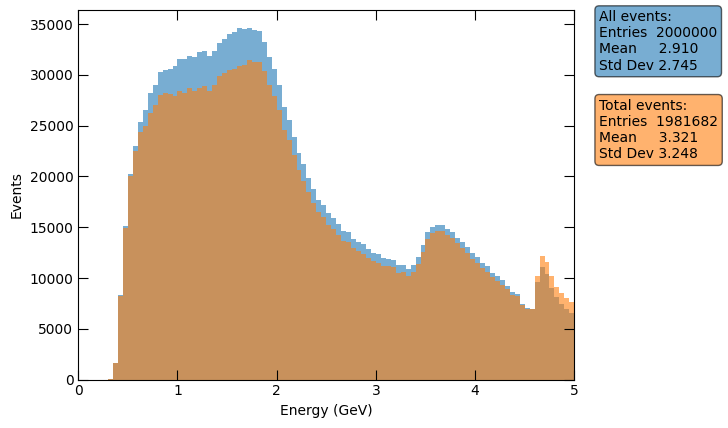

In [39]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)

bins_conf = np.linspace(0, 5, 100 + 1)

*_, bc = ax.hist(df['rec.energy.numu.E'], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'], bc, 'All events')

# Plotting total
total_df = pd.concat(
    (
        df['rec.energy.numu.E'][df['isNC']],
        df['rec.energy.numu.E'][~df['numucontain'] & df['isNuMuCC'] & df['numucosrej']],
        df['rec.energy.numu.E'][df['isNuMuCC'] & df['numufull']],
        df['rec.energy.numu.E'][~(df['numuQuality'] & df['numuBasicQuality'])],
        df['rec.energy.numu.E'][~df['numucosrej'] & df['numuQuality'] & df['numuBasicQuality']]
    )
)

*_, bc = ax.hist(total_df, bins=bins_conf, alpha=0.6)
plot_info(total_df, bc, 'Total events')

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_xlim(0, 5)

# ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');


Things missing in the plot above:
- $\bar{\nu}$ Events
- $\nu_\text{e}$ Events

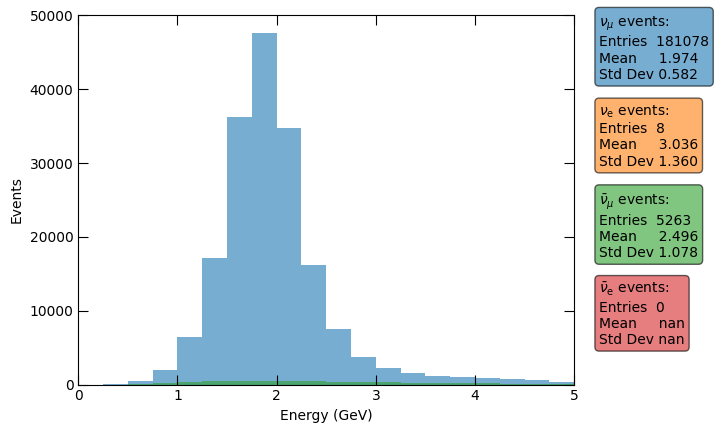

In [40]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)

bins_conf = np.linspace(0, 5, 20 + 1)

_i = df['isNuMuCC'] & df['numufull']
*_, bc = ax.hist(df['rec.energy.numu.E'][_i], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'][_i], bc, r'$\nu_\mu$ events')

_i = df['isNuECC'] & df['numufull']
*_, bc = ax.hist(df['rec.energy.numu.E'][_i], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'][_i], bc, r'$\nu_\text{e}$ events')

_i = df['isANuMuCC'] & df['numufull']
*_, bc = ax.hist(df['rec.energy.numu.E'][_i], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'][_i], bc, r'$\bar{\nu}_\mu$ events')

_i = df['isANuECC'] & df['numufull']
*_, bc = ax.hist(df['rec.energy.numu.E'][_i], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'][_i], bc, r'$\bar{\nu}_\text{e}$ events')

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_xlim(0, 5)

# ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');


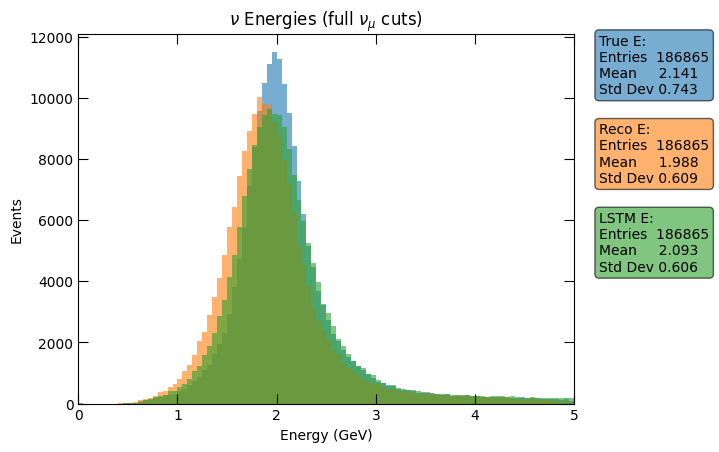

In [41]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)

bins_conf = np.linspace(0, 5, 100 + 1)

*_, bc = ax.hist(df['trueEnu'][df['numufull']], bins=bins_conf, alpha=0.6)
plot_info(df['trueEnu'][df['numufull']], bc, 'True E')

*_, bc = ax.hist(df['rec.energy.numu.E'][df['numufull']], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'][df['numufull']], bc, 'Reco E')

filtered_df = df[df['rec.energy.numu.lstmnu'] >= 0 & df['numufull']]

*_, bc = ax.hist(filtered_df['rec.energy.numu.lstmnu'][df['numufull']], bins=bins_conf, alpha=0.6)
plot_info(filtered_df['rec.energy.numu.lstmnu'][df['numufull']], bc, 'LSTM E')

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_xlim(0, 5)

# ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_title(r'$\nu$ Energies (full $\nu_\mu$ cuts)')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');



#### 4.2 Signal to background

$$
    \text{SBR} = \frac{\text{Number of Signal Events}}{\sqrt{\text{Number of Background Events}}}
$$


In [42]:
n_sg_events_true = len(df['trueEnu'][df['isCC']])
n_bg_events_true = len(df['trueEnu'][~df['isCC']])

print(f'True SBR = {n_sg_events_true / np.sqrt(n_bg_events_true):0.3f}')

True SBR = 492.200


In [43]:
n_sg_events_reco = len(df['rec.energy.numu.E'][df['isCC']])
n_bg_events_reco = len(df['rec.energy.numu.E'][~df['isCC']])

print(f'Reco. SBR = {n_sg_events_reco / np.sqrt(n_bg_events_reco):0.3f}')

Reco. SBR = 492.200


In [44]:
n_sg_events_numu = len(df['rec.energy.numu.E'][df['isNuMuCC']])
n_bg_events_numu = len(df['rec.energy.numu.E'][~df['isNuMuCC']])

print(f'NuMuCC SBR = {n_sg_events_numu / np.sqrt(n_bg_events_numu):0.3f}')

NuMuCC SBR = 453.514


I am not sure if I have calculated this correctly in the cell above. When calculating the SBR for $\nu_\mu$ CC events, do we consider $\nu_\text{e}$ as background events along with NC and cosmic?

#### 4.3 Hadronic Energy

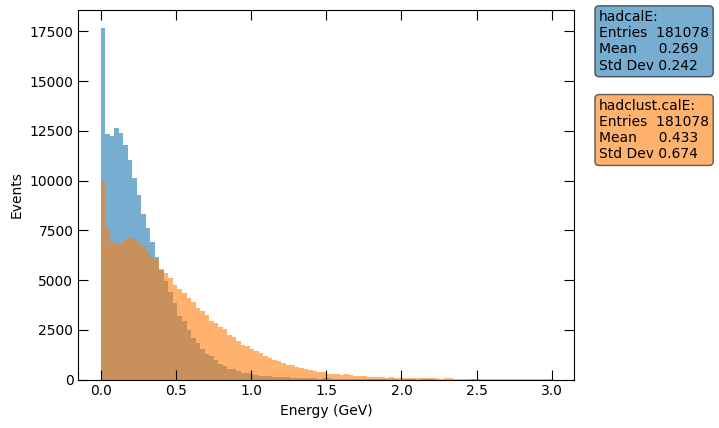

In [45]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)
bins_conf = np.linspace(0, 3, 100 + 1)

_i = df['isNuMuCC'] & df['numufull']

# *_, bc = ax.hist(df['rec.energy.numu.hadtrkE'][_i], bins=bins_conf, alpha=0.6)
# plot_info(df['rec.energy.numu.hadtrkE'][_i], bc, 'hadtrkE')

*_, bc = ax.hist(df['rec.energy.numu.hadcalE'][_i], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.hadcalE'][_i], bc, 'hadcalE')

*_, bc = ax.hist(df['rec.energy.numu.hadclust.calE'][_i], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.hadclust.calE'][_i], bc, 'hadclust.calE')

ax.tick_params(top=True, right=True)

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');


#### 4.4 Quartiles

Calculating the **hadronic energy fraction**.

$$
    \frac{E_\nu - E_\mu}{E_\nu}
$$


In [46]:
had_e_func = (
    (df['rec.energy.numu.lstmnu'] - df['rec.energy.numu.lstmmuon']) 
    / df['rec.energy.numu.lstmnu']
)

print(f'Hadronic Energy Function = \n{had_e_func}')


Hadronic Energy Function = 
0          0.262923
1          0.170504
2          0.119093
3          0.235241
4          0.413819
             ...   
1999995    0.204143
1999996    0.171197
1999997    0.706484
1999998    0.145964
1999999    0.156175
Length: 2000000, dtype: float32


In [47]:
had_e_func.describe()

count    2.000000e+06
mean     3.257090e-01
std      2.225955e-01
min     -2.324981e+01
25%      1.772379e-01
50%      2.454514e-01
75%      4.237345e-01
max      4.778308e+01
dtype: float64

In [48]:
q1 = had_e_func.quantile(q=0.25)
q2 = had_e_func.quantile(q=0.50)
q3 = had_e_func.quantile(q=0.75)


In [49]:
(had_e_func <= q1)

0          False
1           True
2           True
3          False
4          False
           ...  
1999995    False
1999996     True
1999997    False
1999998     True
1999999     True
Length: 2000000, dtype: bool

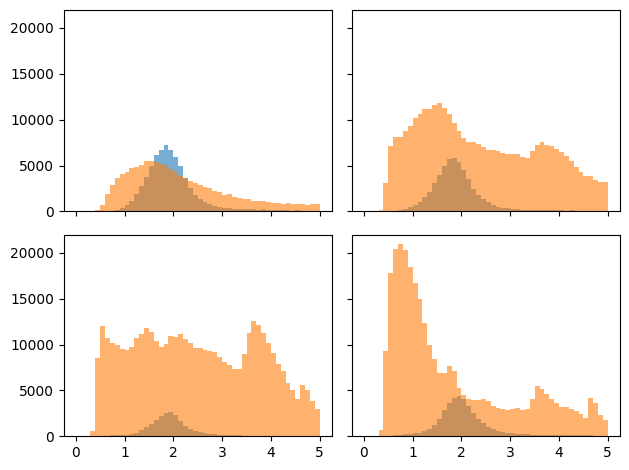

In [53]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

axs = axs.flatten()

bins_conf = np.linspace(0, 5, 50 + 1)

had_e_cuts = [
    (had_e_func <= q1),
    (had_e_func > q1) & (had_e_func <= q2),
    (had_e_func > q2) & (had_e_func <= q3),
    (had_e_func > q3)
]

had_e_cuts.reverse()

for i, had_e_cut in enumerate(had_e_cuts):
    axs[i].hist(
        df['rec.energy.numu.E'][df['numufull']][had_e_cut], 
        bins=bins_conf, alpha=0.6
    )

    _i = 

    axs[i].hist(
        df['rec.energy.numu.E'][_i][had_e_cut], 
        bins=bins_conf, alpha=0.6
    )

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_xlim(0, 5)

ax.set_title('')

plt.tight_layout();


In [51]:
my_data.close()